### Code block 1: Package initialization
Import required packages, do not change.

In [51]:
import argparse
import os, sys
import time
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt

# Import pytorch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.utils import _single, _pair, _triple


### Code block 2: Useful classes
Customized implementation of [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) and [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear), do not change.

In [52]:
class CONV(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1,
                 bias=False, padding_mode='zeros'):
        self.input = None
        self.output = None
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        super(CONV, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation, 
            groups, bias, padding_mode)
    
    def forward(self, input):
        self.input = input
        if '1.4' in torch.__version__:
            self.output = self.conv2d_forward(input, self.weight) #1.4
        else:
            self.output = self._conv_forward(input, self.weight) #1.5
        return self.output
    
class FC(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        self.input = None
        self.output = None
        super(FC, self).__init__(in_features, out_features, bias)
    
    def forward(self, input):
        self.input = input
        self.output = F.linear(input, self.weight, self.bias)
        return self.output

## Lab 2

### Code block 3: SimpleNN implementation

Please follow the instructions in Lab 2(a) and fill in the code in the lines marked **Your code here**

In [57]:
""" 
Lab 2(a)
Build the SimpleNN model by following Table 1
"""

# Create the neural network module: LeNet-5
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # Layer definition
        self.conv1 =     CONV(in_channels = 3, out_channels = 32,kernel_size=5,padding=2, stride=1)
        self.conv2 =     CONV(in_channels = 32, out_channels = 32,kernel_size=5,padding=2, stride=1)
        self.conv3 =     CONV(in_channels = 32, out_channels = 64,kernel_size=5,padding=2, stride=1)
        self.fc1   =     FC(576,64)
        self.fc2   =     FC(64,10)
        self.po1   =  nn.MaxPool2d(kernel_size=3, stride=2)
        self.po2   =  nn.MaxPool2d(kernel_size=3, stride=2)
        self.po3   =  nn.MaxPool2d(kernel_size=3, stride=2)
    def forward(self, x):

        # Forward pass computation
        # Conv 1
            x1= self.conv1(x)
 
        # ReLu1
            x2= F.relu(x1)
         
        # MaxPool
            x3 = self.po1(x2)
        # Conv 2

            x4= self.conv2(x3)
        #ReLu2
            x5= F.relu(x4)
        # MaxPool
            x6 = self.po2(x5)
        # Conv 3

            x7 = self.conv3(x6)
        # ReLu3
            x8 = F.relu(x7)
        # MaxPool
            x9 = self.po3(x8)
        # Flatten
 
            x10= x9.view(x.size(0),-1)
        # FC 1
            x11= self.fc1(x10)
        # ReLu4
            x12 = F.relu(x11)   
        # FC 2
            x13= self.fc2(x12)
        # ReLu5
            x14 = F.relu(x13)  
            out = x14
            
            return out

# GPU check                
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")

# Model Definition  
net = SimpleNN()
net = net.to(device)

# Test forward pass
data = torch.randn(5,3,32,32)
data = data.to(device)
# Forward pass "data" through "net" to get output "out" 
out =  net(data)

# Check output shape
assert(out.detach().cpu().numpy().shape == (5,10))
print("Forward pass successful")

Run on CPU...
Forward pass successful


### Code block 4: Shape observation
Please follow the instructions in Lab 2(a) and fill in the code in the lines marked **Your code here**. Gather the printed results in Table 2 in your report.

In [58]:
def count_parameters(module):
    output=0
    for p in module.parameters():
        if p.requires_grad:
            output = p.numel()+output
    return output

num_para for conv = $$ C_{in}\times(K\times K)\times C_{out} $$
<br>
num_para for FC   =  $$ I \times O + O $$
<br >

num_MACs of Covn2d = $$(C_{in}\times K^2)\times H\times W\times C_{out}$$
num_MACs of FC =$$I\times O $$

In [59]:
"""
Lab 2(b)
"""
# Forward pass of a single image
data = torch.randn(1,3,32,32).to(device)
# Forward pass "data" through "net" to get output "out" 
out =     net(data)

# Iterate through all the CONV and FC layers of the model
for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):

        # Get the input feature map of the module as a NumPy array
        input = module.input.detach().numpy()
        # Get the output feature map of the module as a NumPy array
        output = module.output.detach().numpy()
        
        # Get the weight of the module as a NumPy array
        weight = module.weight.detach().numpy()
        # Compute the number of parameters in the weight
        num_Param = count_parameters(module)
        ## Compute the number of MACs in the layer
        if isinstance(module, CONV):
            C_in = module.input.shape[1]
            C_out = module.output.shape[1]
            H = module.input.shape[2]
            W = module.input.shape[3]
            K = module.kernel_size
            num_MAC = (C_in*K[0]**2)*H*W*C_out 
        if isinstance(module, FC):
    
            C_in = module.input.shape[1]
            C_out = module.output.shape[1]
            num_MAC = (C_in*C_out)


        
        print(f'{name:10} {str(input.shape):20} {str(output.shape):20} {str(weight.shape):20} {str(num_Param):10} {str(num_MAC):10}')


conv1      (1, 3, 32, 32)       (1, 32, 32, 32)      (32, 3, 5, 5)        2400       2457600   
conv2      (1, 32, 15, 15)      (1, 32, 15, 15)      (32, 32, 5, 5)       25600      5760000   
conv3      (1, 32, 7, 7)        (1, 64, 7, 7)        (64, 32, 5, 5)       51200      2508800   
fc1        (1, 576)             (1, 64)              (64, 576)            36928      36864     
fc2        (1, 64)              (1, 10)              (10, 64)             650        640       


## Lab 3 (Bonus)

### Code block 5: Initial weight histogram
Please follow the instructions in Lab 3(a) and fill in the code in the lines marked **Your code here**. Copy the output figures into your report.

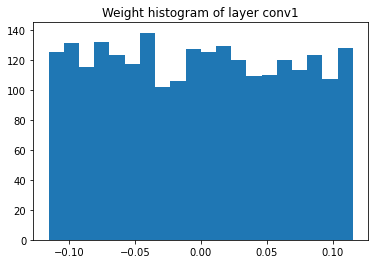

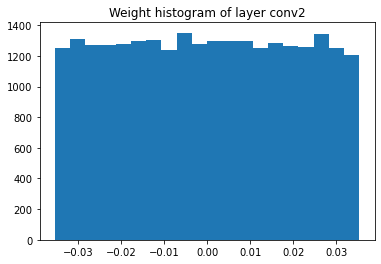

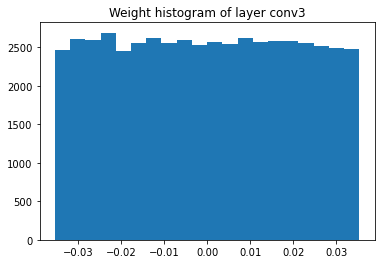

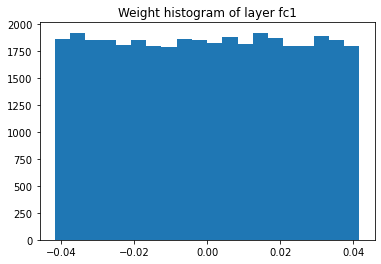

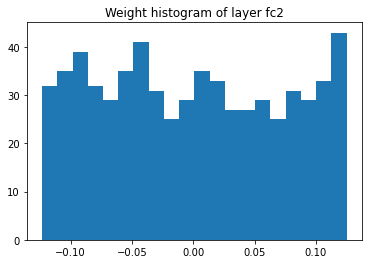

In [60]:
"""
Lab 3(a)
"""
for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the weight of the module as a NumPy array
        weight =  module.weight.detach().numpy()
        
        # Reshape for histogram
        weight = weight.reshape(-1)
        _ = plt.hist(weight, bins=20)
        plt.title("Weight histogram of layer "+name)
        plt.savefig()
        plt.show()

### Code block 6: Gradient histogram
Please follow the instructions in Lab 3(b) and fill in the code in the lines marked **Your code here**. Copy the output figures into your report.

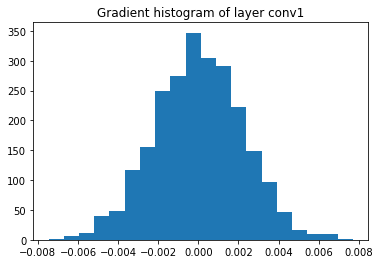

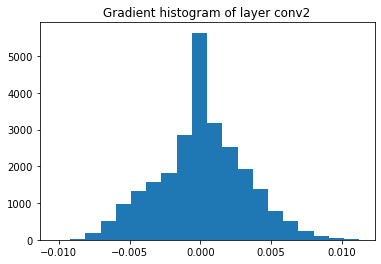

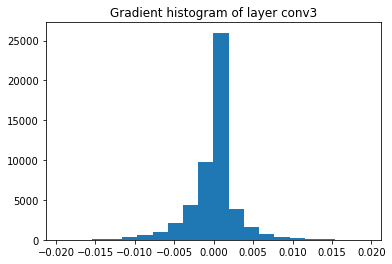

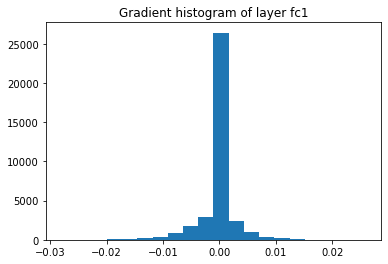

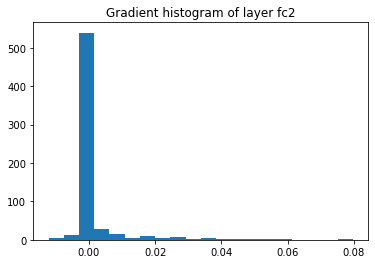

In [49]:
'''
Lab 3(b)
'''
# Loss definition
criterion = nn.MSELoss()
# Random target
target = torch.randn(1, 10).to(device)

# Loss computation
loss = criterion(out,target)     #Your code here
# Backward pass for gradients
loss.backward()

for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the gradient of the module as a NumPy array
        gradient =  module.weight.grad.detach().numpy()  #Your code here
        
        # Reshape for histogram
        gradient = gradient.reshape(-1)
        _ = plt.hist(gradient, bins=20)
        plt.title("Gradient histogram of layer "+name)
        plt.show()


### Code block 7: Zero initialization?
Please follow the instructions in Lab 3(c) and fill in the code in the lines marked **Your code here**. Copy the output figures into your report.

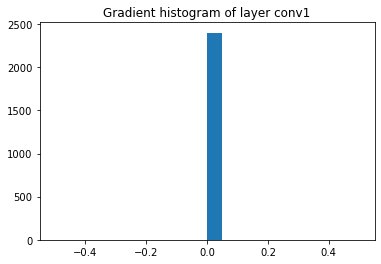

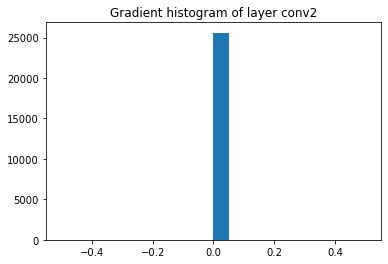

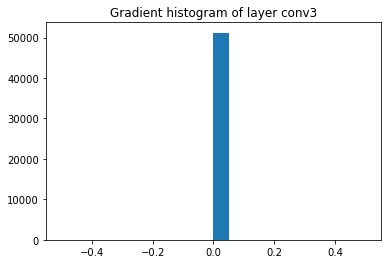

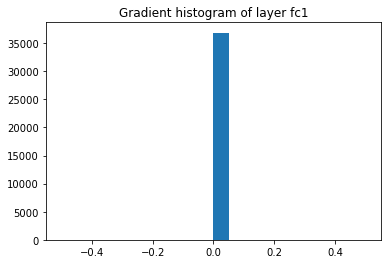

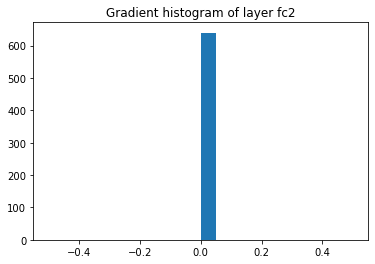

In [50]:
'''
Lab 3(c)
'''
import sys
# Set model weights to zero
for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        torch.nn.init.xavier_uniform_(module.weight)
        module.weight.data.fill_(0)
        if isinstance(module,FC):
            module.bias.data.fill_(0)
        # Set the weight of each module to all zero
             #Your code here

# Reset gradients
net.zero_grad()
# Forward and backward pass
# Random data and target
data = torch.randn(1,3,32,32).to(device)
target = torch.randn(1, 10).to(device)

# Forward pass
out = net(data)     #Your code here
# Loss computation
loss = criterion(out,target)  #Your code here
# Backward pass
loss.backward()

for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the gradient of the module as a NumPy array
        gradient = module.weight.grad.detach().numpy() 
        
        # Reshape for histogram
        gradient = gradient.reshape(-1)
        _ = plt.hist(gradient, bins=20)
        plt.title("Gradient histogram of layer "+name)
        plt.show()